## Define Hyper-Parameters

In [1]:
'''
stateful RNN  
'''

from __future__ import print_function

import matplotlib.pyplot as plt
import numpy as np

from keras.layers import Dense, SimpleRNN, LSTM
from keras.models import Sequential

Using TensorFlow backend.


In [2]:
trainingParams = {}
trainingParams['batchSize'] = 16
trainingParams['unrolledTimesteps'] = 20
trainingParams['inputDimensionality'] = 1
trainingParams['forwardSamplesToPredict'] = 1
trainingParams['outputDimensionality'] = 1 
trainingParams['trainEpochs'] = 100

## Generate Target Dataset

In [3]:
xRange = np.linspace(start=0, stop=25*np.pi, num=25000)
targetData = np.cos( xRange ) * xRange

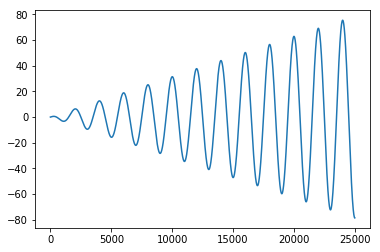

In [4]:
import matplotlib.pyplot as plt
plt.plot( targetData )
plt.show()

## Generate Training Matrix -- Input/Output Batches

In [5]:
def get_batched_data(inputData, trainingParams):
    
    if len(inputData.shape) == 1:
        inputData = np.expand_dims( inputData, 1)

    RNNBatchSamples = int ( trainingParams['batchSize'] * trainingParams['unrolledTimesteps'] )
    totalBatchesInDataset = int ( len(inputData) / RNNBatchSamples )
    
    batchedInputMatrix = np.zeros( ( int(totalBatchesInDataset), 
                                    int(trainingParams['batchSize']), 
                                    int(trainingParams['unrolledTimesteps']), 
                                    int(trainingParams['inputDimensionality']) ) )
    
    batchedOutputMatrix = np.zeros ( ( int(totalBatchesInDataset),
                                      int(trainingParams['batchSize']),
                                      int(trainingParams['outputDimensionality']) ) )
    
    assert trainingParams['outputDimensionality'] == trainingParams['forwardSamplesToPredict']
    
    for iInputDimension in range ( trainingParams['inputDimensionality'] ):
        for iBatch in range( totalBatchesInDataset ):
            startIndex = iBatch * RNNBatchSamples
            endIndex = startIndex + RNNBatchSamples

            batchedInputMatrix[iBatch, :, :, iInputDimension] = np.reshape( inputData[ startIndex:endIndex, iInputDimension ],
                                                                           ( trainingParams['batchSize'],
                                                                            trainingParams['unrolledTimesteps']) )
            # within a batch
            for iBatchElement in range ( trainingParams['batchSize'] ):
                batchElementEnd = startIndex + trainingParams['unrolledTimesteps'] * iBatchElement
                batchElementPredictedTarget = batchElementEnd + trainingParams['forwardSamplesToPredict']
                print( inputData[ batchElementEnd : batchElementPredictedTarget] )
                batchedOutputMatrix[iBatch, iBatchElement ] = inputData[ batchElementEnd : batchElementPredictedTarget]
    
    return batchedInputMatrix, batchedOutputMatrix

In [6]:
batchedInputMatrix, batchedOutputMatrix = get_batched_data ( targetData, trainingParams )

[[ 0.]]
[[ 0.06271037]]
[[ 0.12467772]]
[[ 0.18516392]]
[[ 0.24344061]]
[[ 0.29879395]]
[[ 0.35052941]]
[[ 0.39797635]]
[[ 0.44049253]]
[[ 0.47746844]]
[[ 0.50833142]]
[[ 0.53254965]]
[[ 0.54963581]]
[[ 0.55915063]]
[[ 0.56070601]]
[[ 0.55396796]]
[[ 0.53865926]]
[[ 0.51456168]]
[[ 0.481518]]
[[ 0.43943358]]
[[ 0.38827766]]
[[ 0.32808424]]
[[ 0.25895261]]
[[ 0.1810475]]
[[ 0.09459887]]
[[ -9.87039401e-05]]
[[-0.10268701]]
[[-0.21274555]]
[[-0.32979323]]
[[-0.45329052]]
[[-0.58264179]]
[[-0.71719817]]
[[-0.85626063]]
[[-0.99908337]]
[[-1.1448776]]
[[-1.29281549]]
[[-1.44203447]]
[[-1.59164169]]
[[-1.74071881]]
[[-1.88832685]]
[[-2.03351132]]
[[-2.17530746]]
[[-2.31274555]]
[[-2.4448564]]
[[-2.57067686]]
[[-2.68925532]]
[[-2.79965731]]
[[-2.90097101]]
[[-2.99231272]]
[[-3.07283227]]
[[-3.1417183]]
[[-3.19820342]]
[[-3.24156918]]
[[-3.27115089]]
[[-3.28634215]]
[[-3.28659919]]
[[-3.27144497]]
[[-3.24047287]]
[[-3.19335018]]
[[-3.12982121]]
[[-3.04971001]]
[[-2.95292279]]
[[-2.83944987]]
[

In [7]:
batchedInputMatrix.shape

(78, 16, 20, 1)

In [8]:
batchedOutputMatrix.shape

(78, 16, 1)

## Define Model Architecture

https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/

In [9]:
print('Creating Model')
model = Sequential()

# input layer 
model.add( LSTM( 10,
                batch_input_shape = ( trainingParams['batchSize'], 
                                      trainingParams['unrolledTimesteps'],
                                      trainingParams['inputDimensionality'] ),
                return_sequences = False, # needed in case we stack LSTM layers
                stateful = True, # required for stateful LSTMs
                implementation = 2) ) 
# output layer
model.add( Dense( 10, activation='sigmoid') )
# output layer
model.add( Dense( 1, activation='linear') )

Creating Model


In [10]:
model.compile(loss='mse', optimizer='rmsprop')

## Training Loop

In [11]:
model.reset_states()
for iEpoch in range( trainingParams['trainEpochs'] ):
    for iBatch in range (  batchedInputMatrix.shape[0] ):
        model.fit( batchedInputMatrix[iBatch],
                   batchedOutputMatrix[iBatch],
                   batch_size = trainingParams['batchSize'],
                   verbose = 0,
                   epochs = 1,
                   shuffle = False)
    model.reset_states()


In [12]:
predictedOutput = np.array([])
targetOutput = np.array([])

16 16
32 16
48 16
64 16
80 16
96 16
112 16
128 16
144 16
160 16
176 16
192 16
208 16
224 16
240 16
256 16
272 16
288 16
304 16


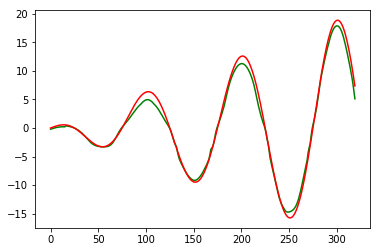

In [13]:
for iEpoch in range (20):
    currentPredictions = model.predict(batchedInputMatrix[iEpoch], batch_size=trainingParams['batchSize'])
    currentTargets = batchedOutputMatrix[iEpoch]
    if iEpoch == 0:
        predictedOutput = currentPredictions
        targetOutput = currentTargets
    else:
        print(str(len(predictedOutput)) + ' ' + str(len(currentPredictions)))
        predictedOutput = np.vstack ( ( predictedOutput, currentPredictions ) )
        targetOutput = np.vstack( ( targetOutput, currentTargets ) )
    
plt.figure()
plt.plot( predictedOutput, 'g' )
plt.plot( targetOutput, 'r' )
plt.show()

In [ ]:
predicted_output.shape

## Save Model